# Regression analysis with SVD decomposition for a real covariance and a thermal system (UAM)

In [1]:
import pandas as pd
import numpy as np
from numpy.random import multivariate_normal, normal
from numpy.linalg import cholesky, svd
from scipy.sparse.linalg import lsqr
from itertools import accumulate
from sklearn.linear_model import LinearRegression
from scipy.linalg import lstsq
from scipy.optimize import nnls

import pytest

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sandy
import serpentTools as sts

## Real covariance with same groups as the sensitivity (1000)

In [4]:
sens = sts.read("UAM.i_sens0.m")

INFO:  Reading UAM.i_sens0.m
INFO:    - done


In [5]:
nzai = sens.zais[922350]

sensitivity = {}
e = sens.energies

npert = sens.perts['capture xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["capture xs"] = pd.Series(s, index=e[1:])
npert = sens.perts['fission xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["fission xs"] = pd.Series(s, index=e[1:])
npert = sens.perts['ela scatt xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["ela scatt xs"] = pd.Series(s, index=e[1:])
npert = sens.perts['inl scatt xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["inl scatt xs"] = pd.Series(s, index=e[1:])

In [6]:
tape = sandy.get_endf6_file("jeff_33", "xs", 922350)
mt = [2, 4, 18, 102]
err = tape.get_errorr(err=1, xs=True, nubar=False, chi=False, mubar=False, errorr33_kws=dict(mt=mt, ek=e), verbose=False)["errorr33"]
cov = err.get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    



 njoy 2016.71  14Jul23                                       09/28/23 07:46:53
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.1s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 8.6s

 errorr...                                                                9.2s

 ---message from grpav---mf  3 mt   4
                          has threshold gt highest union energy.

 ---message from grpav---mf  3 mt  16
                          has threshold gt highest union energy.

 ---message from grpav---mf  3 mt  17
                          has threshold gt highest union energy.

 ---message from grpav---mf  3 mt  37
                          has threshold gt highest union energy.

 processing mat  9228
 ---

/home/runner/.local/lib/python3.11/site-packages/sandy-1.1-py3.11.egg/sandy/core/endf6.py:962: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [7]:
C = cov.data.copy()
#print(f"condition number original matrix: {np.linalg.cond(C):>10}")
C = pd.DataFrame(C.values + np.diag(np.diag(C.values) * 0.5 / 100 + 0.0001), index=C.index, columns=C.columns)
#print(f"condition number adjusted matrix: {np.linalg.cond(C):>10}")
cov_ = sandy.CategoryCov(C)

In [8]:
U, S, V = svd(C)
Lambda12 = np.diag(np.sqrt(S))

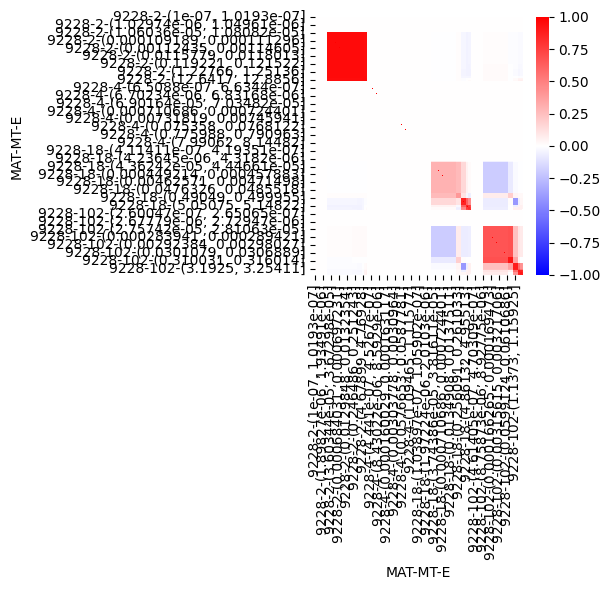

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cov_.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

In [10]:
M = cov.data.shape[0]  # number of parameters

frac = S / S.sum()
acc = np.array(list(accumulate(frac)))
r = acc[acc < 0.98].size + 1

N = 5000  # number of samples

print(f"sample size:                  {N:>10}\nnumber of parameters:         {M:>10}\nreduced number of parameters: {r:>10}")

sample size:                        5000
number of parameters:               4000
reduced number of parameters:       3450


In [11]:
# non correlated, standardized sample
X_ = normal(loc=1., scale=1., size=N * M).reshape(N, M)

# correlated sample
X = X_ @ (U @ Lambda12).T

In [12]:
def model(x):
    sens_all = pd.concat([sensitivity["ela scatt xs"], sensitivity["inl scatt xs"], sensitivity["fission xs"], sensitivity["capture xs"]], ignore_index=True).values
    return sens_all @ x

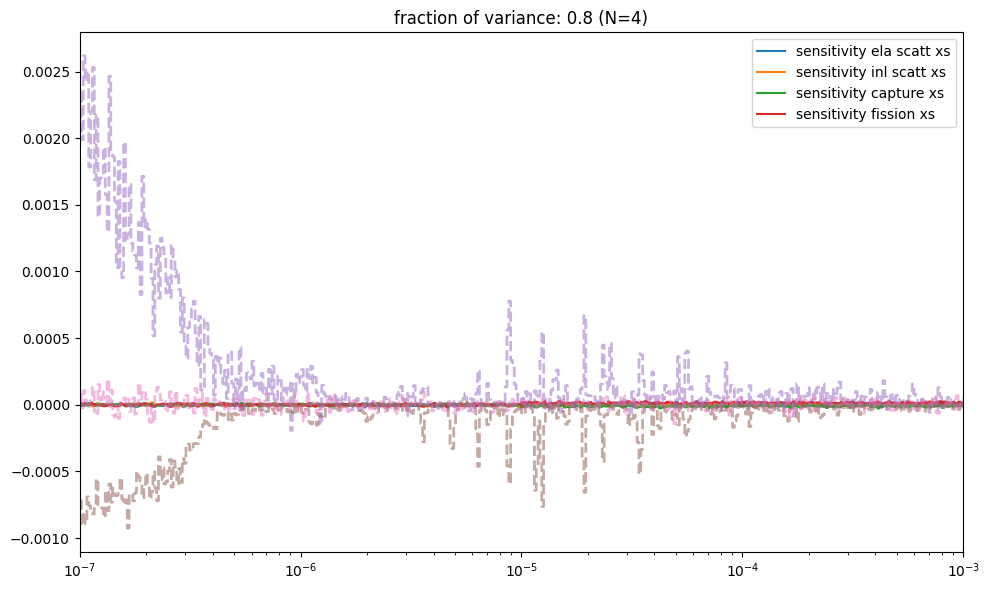

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

model = model

fv = 0.80
n = acc[acc < fv].size + 1
Y = model(X[:n, :].T)
Z = lstsq(X[:n, :], Y)[0]

pd.Series(Z[(e.size - 1)*0:(e.size - 1)*1], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity ela scatt xs")
pd.Series(Z[(e.size - 1)*1:(e.size - 1)*2], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity inl scatt xs")
pd.Series(Z[(e.size - 1)*2:(e.size - 1)*3], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity capture xs")
pd.Series(Z[(e.size - 1)*3:(e.size - 1)*4], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity fission xs")
sensitivity["capture xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["fission xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["ela scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["inl scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
ax.legend()

ax.set(xlim=[1e-7, 1e-3], title=f"fraction of variance: {fv} (N={n})")

fig.tight_layout()

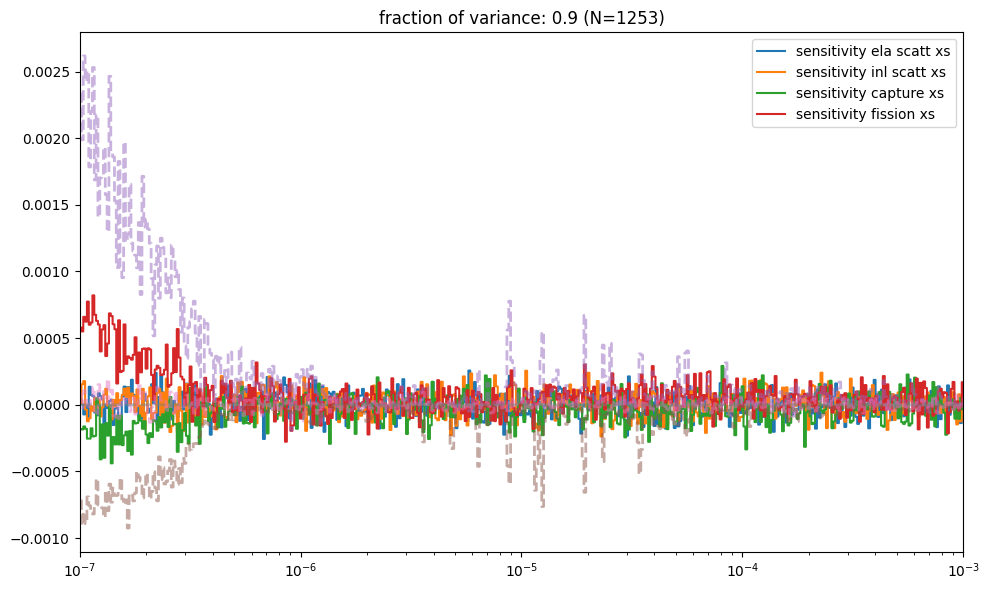

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

model = model

fv = 0.90
n = acc[acc < fv].size + 1
Y = model(X[:n, :].T)
Z = lstsq(X[:n, :], Y)[0]

pd.Series(Z[(e.size - 1)*0:(e.size - 1)*1], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity ela scatt xs")
pd.Series(Z[(e.size - 1)*1:(e.size - 1)*2], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity inl scatt xs")
pd.Series(Z[(e.size - 1)*2:(e.size - 1)*3], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity capture xs")
pd.Series(Z[(e.size - 1)*3:(e.size - 1)*4], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity fission xs")
sensitivity["capture xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["fission xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["ela scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["inl scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
ax.legend()

ax.set(xlim=[1e-7, 1e-3], title=f"fraction of variance: {fv} (N={n})")

fig.tight_layout()

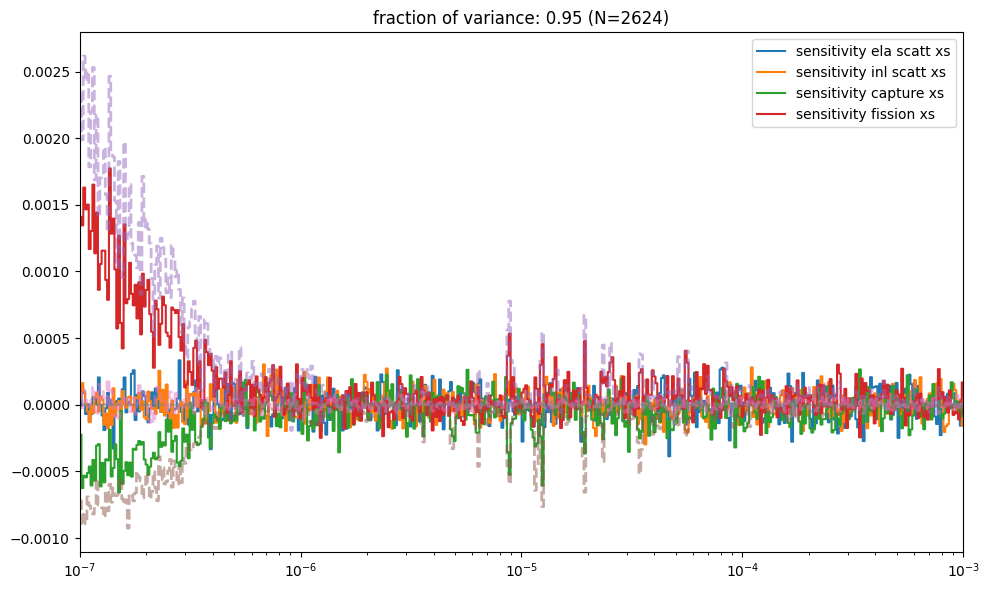

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

model = model

fv = 0.95
n = acc[acc < fv].size + 1
Y = model(X[:n, :].T)
Z = lstsq(X[:n, :], Y)[0]

pd.Series(Z[(e.size - 1)*0:(e.size - 1)*1], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity ela scatt xs")
pd.Series(Z[(e.size - 1)*1:(e.size - 1)*2], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity inl scatt xs")
pd.Series(Z[(e.size - 1)*2:(e.size - 1)*3], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity capture xs")
pd.Series(Z[(e.size - 1)*3:(e.size - 1)*4], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity fission xs")
sensitivity["capture xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["fission xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["ela scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["inl scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
ax.legend()

ax.set(xlim=[1e-7, 1e-3], title=f"fraction of variance: {fv} (N={n})")

fig.tight_layout()

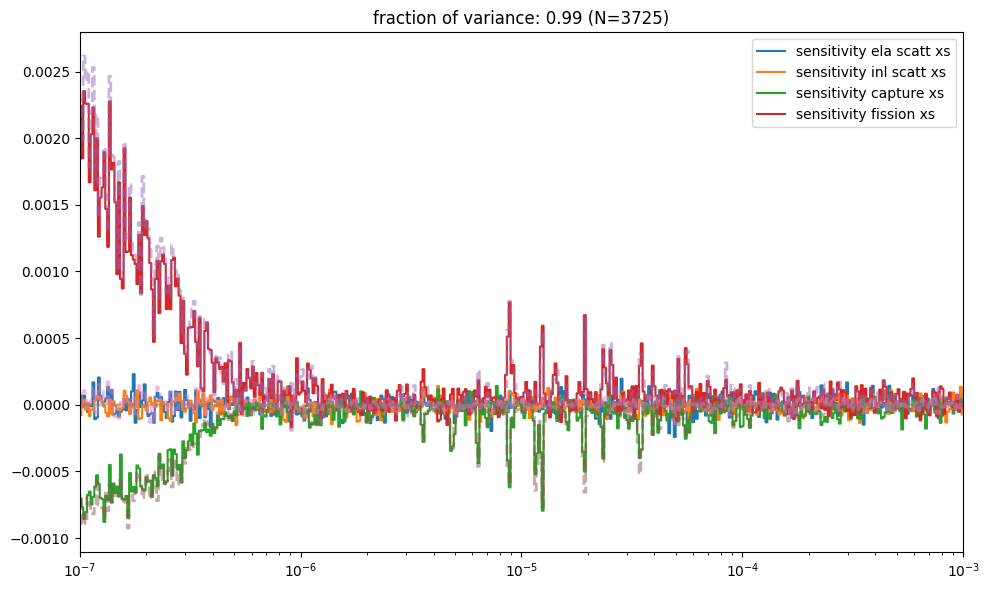

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

model = model

fv = 0.99
n = acc[acc < fv].size + 1
Y = model(X[:n, :].T)
Z = lstsq(X[:n, :], Y)[0]

pd.Series(Z[(e.size - 1)*0:(e.size - 1)*1], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity ela scatt xs")
pd.Series(Z[(e.size - 1)*1:(e.size - 1)*2], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity inl scatt xs")
pd.Series(Z[(e.size - 1)*2:(e.size - 1)*3], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity capture xs")
pd.Series(Z[(e.size - 1)*3:(e.size - 1)*4], index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre", label="sensitivity fission xs")
sensitivity["capture xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["fission xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["ela scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
sensitivity["inl scatt xs"].plot(ax=ax, ls="--", lw=2, drawstyle="steps-pre", alpha=.5)
ax.legend()

ax.set(xlim=[1e-7, 1e-3], title=f"fraction of variance: {fv} (N={n})")

fig.tight_layout()